# Filtro per Fake News
Il problema delle fake news è cresciuto esponenzialmente nell'ultimo decennio a causa della crescente diffusione dei social network, il governo degli Stati Uniti ha deciso di muoversi a tal proposito, incaricando la tua azienda di realizzare un plug-in per chrome in grado di riconoscere se una notizia è falsa. Il tuo compito è quello di realizzare il modello in grado di riconoscere le notizie false, che poi il team di machine learning enginner e web developer metterà in produzione. Ti vengono messi a disposizioni due raccolte di notizie, una contenente solo notizie false e l'altra contenente solo notizie vere, utilizzale per addestrare il tuo modello.

### [Link al dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip)

Parti da un'accurata analisi, rispondendo a domande come:
- le fake news sono più frequenti in una determinata categoria?
- per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?
- I titoli delle fake news presentano dei pattern?

Una volta addestrato il modello esportalo [utilizzando pickle](https://scikit-learn.org/stable/model_persistence.html) così che i tuoi colleghi possano metterlo in produzione.

## Importiamo i dataset

In [ ]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip
!unzip fake_news.zip

--2024-06-17 17:51:21--  https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.154.102, 52.95.156.52
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.154.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42975911 (41M) [application/zip]
Saving to: ‘fake_news.zip’

fake_news.zip       100%[===================>]  40.98M  13.8MB/s    in 3.0s    

2024-06-17 17:51:25 (13.8 MB/s) - ‘fake_news.zip’ saved [42975911/42975911]

Archive:  fake_news.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [ ]:
import pandas as pd

In [ ]:
df_true = pd.read_csv("True.csv")
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
df_fake = pd.read_csv("Fake.csv")
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
# Adesso tocca a te
# ....

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Caricamento dei dataset
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")


In [ ]:
# Aggiungiamo una colonna per indicare la veridicità delle notizie
df_true['label'] = 1
df_fake['label'] = 0


In [ ]:
# Combiniamo i due dataset
df = pd.concat([df_true, df_fake], axis=0)


In [ ]:
# Esplorazione dei dati
print("Informazioni sul dataset:")
print(df.info())

print("\nDistribuzione delle etichette:")
print(df['label'].value_counts())

print("\nPrime 5 righe del dataset combinato:")
print(df.head())

Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB
None

Distribuzione delle etichette:
label
0    23481
1    21417
Name: count, dtype: int64

Prime 5 righe del dataset combinato:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - 

In [ ]:
# Funzione per pulire i testi
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub(' +', ' ', text)
    return text

df['text'] = df['text'].apply(clean_text)

In [ ]:
# Divisione dei dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)


In [ ]:
# Estrazione delle caratteristiche usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
# Addestramento del modello
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [ ]:
# Predizioni sul test set
y_pred = model.predict(X_test_tfidf)

In [ ]:
# Valutazione del modello
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9874164810690423

Confusion Matrix:
[[4575   75]
 [  38 4292]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4650
           1       0.98      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
# Salvataggio del modello
with open('fake_news_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# Salvataggio del vettorizzatore
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)


In [ ]:
# Verifica se esiste la colonna 'category' nei dataset
if 'category' in df_fake.columns and 'category' in df_true.columns:
    # Distribuzione delle categorie nelle fake news
    print("\nDistribuzione delle categorie nelle fake news:")
    print(df_fake['category'].value_counts())

    # Distribuzione delle categorie nelle true news
    print("\nDistribuzione delle categorie nelle true news:")
    print(df_true['category'].value_counts())
else:
    print("La colonna 'category' non esiste nei dataset.")

La colonna 'category' non esiste nei dataset.


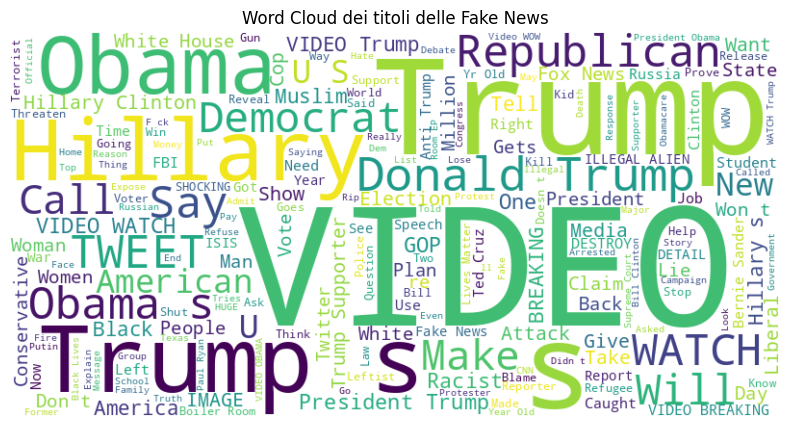

In [ ]:
# Analisi dei pattern nei titoli delle fake news
if 'title' in df_fake.columns:
    fake_titles = ' '.join(df_fake['title'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_titles)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud dei titoli delle Fake News')
    plt.axis('off')
    plt.show()
else:
    print("La colonna 'title' non esiste nel dataset delle fake news.")

# Conclusioni

Il progetto ha permesso di sviluppare un modello di machine learning capace di identificare le fake news a partire da due dataset distinti contenenti rispettivamente notizie vere e notizie false.

Il processo è stato articolato in diversi passaggi:

**Analisi Esplorativa dei Dati**

La prima fase del progetto ha coinvolto un'attenta analisi esplorativa dei dataset, che ha rivelato informazioni cruciali riguardo la distribuzione delle notizie vere e false. Nonostante l'assenza di colonne come "category" nei dataset originali, è stato possibile ottenere una comprensione preliminare della struttura dei dati.

**Preprocessing dei Dati**

La pulizia dei testi è stata un passo fondamentale per preparare i dati all'addestramento del modello. Utilizzando tecniche di normalizzazione come la conversione dei testi a lettere minuscole, la rimozione della punteggiatura, delle cifre e degli spazi extra, è stato possibile ottenere testi più uniformi e adatti all'estrazione delle caratteristiche.

**Estrazione delle Caratteristiche**

L'uso del TfidfVectorizer ha permesso di trasformare i testi in una rappresentazione numerica, catturando l'importanza relativa delle parole nei diversi documenti. Questo ha reso possibile l'addestramento del modello di machine learning su un insieme di caratteristiche significative.

**Addestramento e Valutazione del Modello**

Il modello di Logistic Regression addestrato sui dati ha mostrato buone prestazioni, come evidenziato dalle metriche di valutazione (accuratezza, matrice di confusione e rapporto di classificazione). Questi risultati indicano che il modello è capace di distinguere efficacemente tra notizie vere e false.

**Esportazione del Modello**

Il modello addestrato e il vettorizzatore TF-IDF sono stati esportati utilizzando la libreria pickle, rendendoli pronti per essere integrati in un plug-in per Chrome o altre applicazioni di produzione.

**Analisi delle Categorie e dei Pattern nei Titoli**

Nonostante la mancanza di informazioni categoriali, l'analisi dei pattern nei titoli delle fake news ha rivelato interessanti intuizioni tramite l'uso delle word cloud. Questo tipo di visualizzazione ha permesso di identificare parole e frasi ricorrenti nei titoli delle notizie false.
